<a href="https://colab.research.google.com/github/CodeByGui-hub/ml-projects/blob/main/classificacao/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importando bibliotecas e dependências**

In [ ]:
!pip install tensorflow
!pip install keras
!pip install Pillow

In [ ]:
import keras
import os
import PIL
import shutil
import random
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
import matplotlib.pyplot as plt

# **Dataset**

In [ ]:
from google.colab import files
files.upload()
!unzip kagglecatsanddogs_5340.zip

In [ ]:
# !rm -rf PetImages_reduced/

In [ ]:
# Criando um Dataset reduzido.
dataset_dir = '/content/PetImages'
reduced_dir = '/content/PetImages_reduced'
classes = ['Cat', 'Dog']
images_per_class = 800

os.makedirs(reduced_dir, exist_ok=True)

for c in classes:
    os.makedirs(os.path.join(reduced_dir, c), exist_ok=True)

for c in classes:
    src_path = os.path.join(dataset_dir, c)
    dst_path = os.path.join(reduced_dir, c)

    all_files = os.listdir(src_path)

    selected_files = random.sample(all_files, images_per_class)

    for file in selected_files:
        shutil.copy(os.path.join(src_path, file), os.path.join(dst_path, file))

In [ ]:
# Definindo parâmetros
img_height = 160
img_width = 160
image_color_channel = 3
image_color_channel_size = 255
image_size = (img_height, img_width)
image_shape = image_size + (image_color_channel,)
batch_size = 32
validation_split = 0.2
learning_rate = 0.001

In [ ]:
# Removendo imagens corrompidas do Dataset, se houver.
for c in classes:
    path = os.path.join(reduced_dir, c)
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        try:
            img = Image.open(file_path)
            img.verify()
            if len(img.getbands()) not in [1, 3, 4]:
                print(f"Removendo imagem com número de canais inválido (2 canais): {file_path}")
                os.remove(file_path)
                continue

            img_bytes = tf.io.read_file(file_path)
            decoded_img = tf.image.decode_image(img_bytes, channels=image_color_channel)

        except (IOError, SyntaxError) as e:
            print(f"Removendo imagem corrompida: {file_path} (Erro PIL: {e})")
            os.remove(file_path)
        except tf.errors.InvalidArgumentError as e:
            print(f"Removendo imagem que TensorFlow não consegue decodificar: {file_path} (Erro TF: {e})")
            os.remove(file_path)
        except Exception as e:
            print(f"Removendo imagem devido a erro inesperado: {file_path} (Erro: {e})")
            os.remove(file_path)

Removendo imagem que TensorFlow não consegue decodificar: /content/PetImages_reduced/Dog/11233.jpg (Erro TF: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Number of channels inherent in the image must be 1, 3 or 4, was 2 [Op:DecodeImage] name: )


### **Dividindo o Dataset em treino e teste**

In [ ]:
# Dataset de treino
train_ds = image_dataset_from_directory(
    reduced_dir,
    validation_split = validation_split,
    subset = 'training',
    seed = 55,
    image_size = image_size,
    batch_size = batch_size,
    shuffle = True
)

Found 1599 files belonging to 2 classes.
Using 1280 files for training.


In [ ]:
# Dataset de teste/validação
test_ds = image_dataset_from_directory(
    reduced_dir,
    validation_split = validation_split,
    subset = 'validation',
    seed = 55,
    image_size = image_size,
    batch_size = batch_size,
    shuffle = True
)

Found 1599 files belonging to 2 classes.
Using 319 files for validation.


In [ ]:
print(train_ds.class_names)

['Cat', 'Dog']


In [ ]:
# Tenta carregar a imagem mesmo se ela estiver incompleta, evitando erros durante o carregamento do dataset. Usado geralmente em datasets enormes com poucas amostras ruins.
PIL.ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
# Otimizando o pipeline com .cache e .prefetch
autotune = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=autotune)
test_ds = test_ds.cache().prefetch(buffer_size=autotune)

In [ ]:
# Plotando as imagens do Dataset
def plot_dataset(dataset):

    plt.gcf().clear()
    plt.figure(figsize = (15, 15))

    for features, labels in dataset.take(1):

        for i in range(9):
            plt.subplot(3, 3, i + 1)
            plt.axis('off')

            plt.imshow(features[i].numpy().astype('uint8'))
            plt.title(classes[labels[i]])

# **Data Augmentation**

In [ ]:
# Aumentando nossas amostras para um melhor treinamento
data_augmentation = models.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])

In [ ]:
# Plotando as imagens após o aumento dos dados
def plot_dataset_data_augmentation(dataset):

    plt.gcf().clear()
    plt.figure(figsize = (15, 15))

    for features, _ in dataset.take(1):
        feature = features[0]

        for i in range(9):
            feature_data_augmentation = data_augmentation(tf.expand_dims(feature, 0))
            plt.subplot(3, 3, i + 1)
            plt.axis('off')

            plt.imshow(feature_data_augmentation[0] / image_color_channel_size)

# **Rescaling**

In [ ]:
# Normalizando as imagens do Dataset
rescaling = Rescaling(
    1./ (image_color_channel_size / 2),
    offset = -1,
    input_shape = image_shape
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# **Transfer Learning**

In [ ]:
# Transferindo aprendizado com o modelo MobileNetV2
model_transfer_learning = MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=image_shape
)

model_transfer_learning.trainable = False

model_transfer_learning.summary()

# **EarlyStopping**

In [ ]:
# Callback que interrompe o treino se a métrica monitorada (loss) não melhorar por épocas. Evita treino desnecessário quando já convergiu.
early_stopping = EarlyStopping(monitor = 'loss', patience = 3)

# **Model**

In [ ]:
# Montando e compilando o modelo final
model = models.Sequential([
    rescaling,
    data_augmentation,
    model_transfer_learning,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer = keras.optimizers.Adam(learning_rate = learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Treinamento do modelo
epochs = 200
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 47s 897ms/step - accuracy: 0.7461 - loss: 0.5109 - val_accuracy: 0.9718 - val_loss: 0.1197
Epoch 2/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 761ms/step - accuracy: 0.9021 - loss: 0.2308 - val_accuracy: 0.9843 - val_loss: 0.0730
Epoch 3/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 804ms/step - accuracy: 0.9226 - loss: 0.1862 - val_accuracy: 0.9875 - val_loss: 0.0608
Epoch 4/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 780ms/step - accuracy: 0.9276 - loss: 0.1706 - val_accuracy: 0.9875 - val_loss: 0.0488
Epoch 5/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 788ms/step - accuracy: 0.9254 - loss: 0.1618 - val_accuracy: 0.9875 - val_loss: 0.0438
Epoch 6/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 761ms/step - accuracy: 0.9322 - loss: 0.1576 - val_accuracy: 0.9875 - val_loss: 0.0420
Epoch 7/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 786ms/step - accuracy: 0.9385 - loss: 0.1494 - val_accuracy: 0.9875 - val_loss: 0.0382
Epoch 8/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 785ms/step - accuracy: 0.9655 - loss: 0.1189 - 

In [ ]:
def plot_model():

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(accuracy))

    plt.gcf().clear()
    plt.figure(figsize = (15, 8))

    plt.subplot(1, 2, 1)
    plt.title('Training and Validation Accuracy')
    plt.plot(epochs_range, accuracy, label = 'Training Accuracy')
    plt.plot(epochs_range, val_accuracy, label = 'Validation Accuracy')
    plt.legend(loc = 'lower right')

    plt.subplot(1, 2, 2)
    plt.title('Training and Validation Loss')
    plt.plot(epochs_range, loss, label = 'Training Loss')
    plt.plot(epochs_range, val_loss, label = 'Validation Loss')
    plt.legend(loc = 'lower right')

    plt.show()

<Figure size 640x480 with 0 Axes>

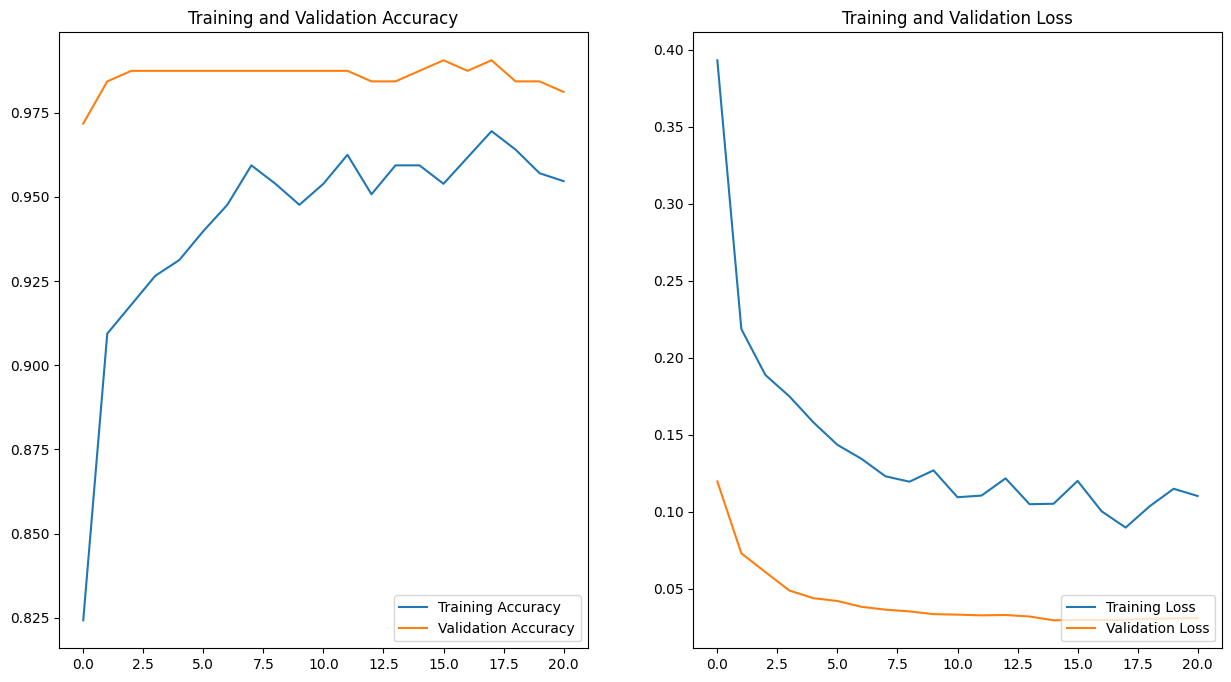

In [ ]:
plot_model()